<img src="img/logo.png"  />

# Bayesian Risk Modelling

This notebook defines a probabilistic model using PyMC3, with a Poisson distribution representing the number of events per year, where the mean (μ) is set to our initial minimum probability of attack per year. The model is then sampled using the Metropolis algorithm, and the posterior distribution is visualized using a posterior plot.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from statistics import NormalDist

from sklearn.preprocessing import scale
import math
import random

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pymc3 as pm
import arviz as az

In [4]:
# Define the minimum and maximum values for probability of event
MIN = .07
MAX = .17
# Define the log loss mean and standard deviation
LOG_MEAN = 12.55
LOG_STD = 3.06

In [5]:
# Define the number of trials
NUM_SAMPLES = 1000
CONFIDENCE_INTERVAL = .95

In [6]:
# Define the uniform distribution bounds probability
lower_bound = MIN
upper_bound = MAX

In [7]:
# Define the log-normal distribution parameters
MU = np.log(LOG_MEAN)
SIGMA = np.log(LOG_STD)

In [8]:
# Define the Poisson distribution with mean mu=MIN
with pm.Model() as freq_model:
    events_per_year = pm.Poisson('events_per_year', mu=MIN)

In [9]:
# Sample from the model
with freq_model:
    trace = pm.sample(NUM_SAMPLES, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [events_per_year]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.


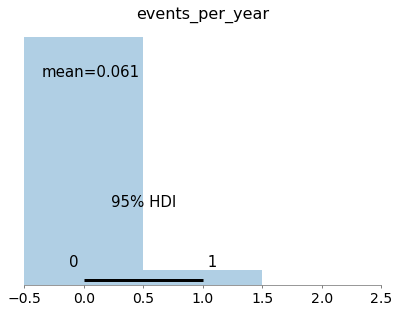

In [10]:
# Plot the results
pm.plot_posterior(trace, hdi_prob=CONFIDENCE_INTERVAL)
plt.show()

To modify the code to have a minimum and maximum mean probability (μ) for events per year, you can introduce a uniform distribution for  μ within the desired range.

In [11]:
# Define the PyMC3 model
with pm.Model() as freq_model:
    mu = pm.Uniform('mu', lower_bound, upper_bound)
    events_per_year = pm.Poisson('events_per_year', mu=mu)

In [12]:
# Sample from the model
with freq_model:
    trace = pm.sample(NUM_SAMPLES, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu]
>Metropolis: [events_per_year]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.


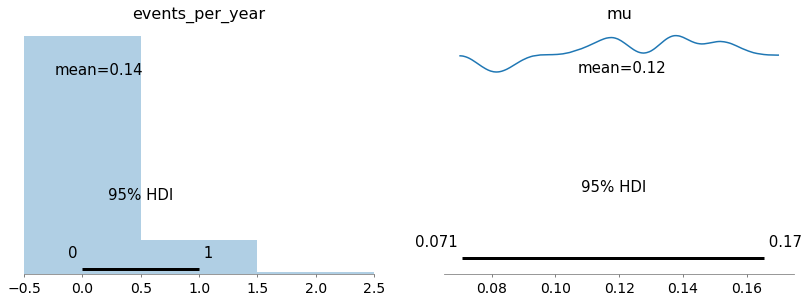

In [13]:
# Plot the results
pm.plot_posterior(trace, hdi_prob=CONFIDENCE_INTERVAL)
plt.show()

In [14]:
# Define the PyMC3 model
with pm.Model() as magn_model:
    magnitude = pm.Lognormal('magnitude', mu=MU, sigma=SIGMA)

In [15]:
# Sample from the model
with magn_model:
    trace = pm.sample(NUM_SAMPLES, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [magnitude]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8813339777613045, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.


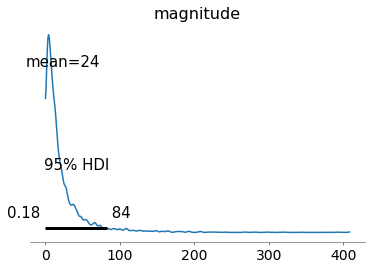

In [16]:
# Plot the results
pm.plot_posterior(trace, hdi_prob=CONFIDENCE_INTERVAL)
plt.show()

In [17]:
df = pm.trace_to_dataframe(trace)

In [18]:
df.head()

,magnitude
0,0.483830
1,184.635522
2,40.084459
3,4.962368
4,10.010393


Text(0.5, 0, 'Potential Loss Magnitudes [$ MM]')

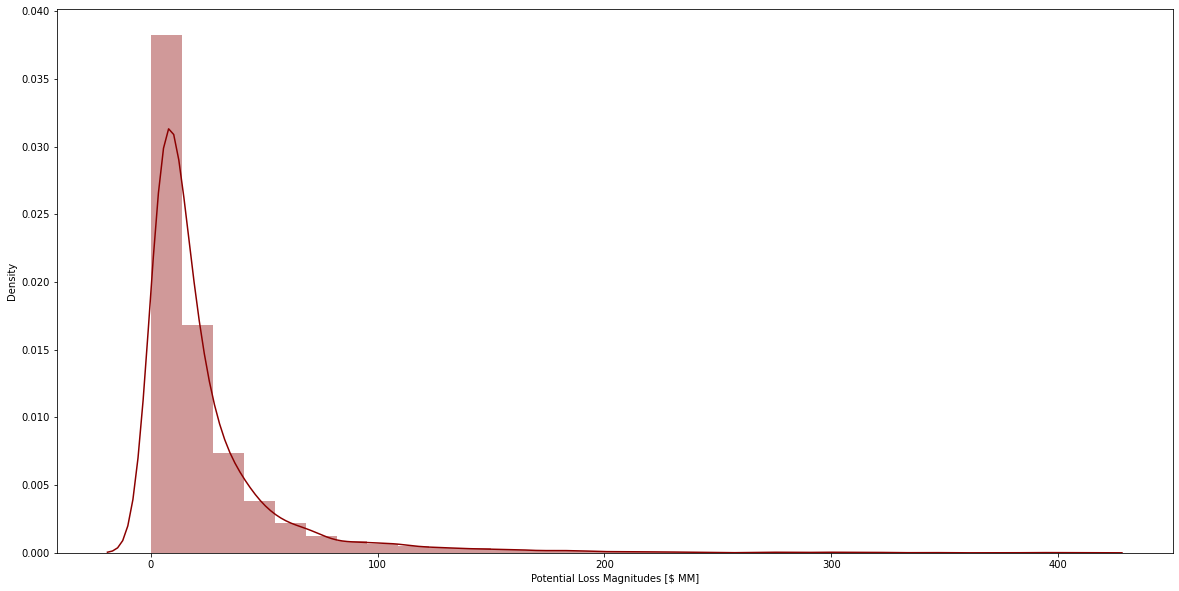

In [19]:
plt.figure(figsize=(20, 10))
sns.distplot(df.magnitude, bins=30, color='darkred')
plt.xlabel('Potential Loss Magnitudes [$ MM]')

In [20]:
# Define the PyMC3 model
with pm.Model() as risk_model:

    # Model magnitude as a log-normal distribution
    magnitude = pm.Lognormal('magnitude', mu=MU, sigma=SIGMA)

    # Model frequency as a Poisson distribution
    frequency = pm.Poisson('frequency', mu=MIN)
    
    # Calculate risk as the multiplication of frequency and loss
    risk = pm.Deterministic('risk', pm.math.sum(frequency * magnitude))


In [21]:
# Sample from the model
with risk_model:
    trace = pm.sample(NUM_SAMPLES, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [magnitude]
>Metropolis: [frequency]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.


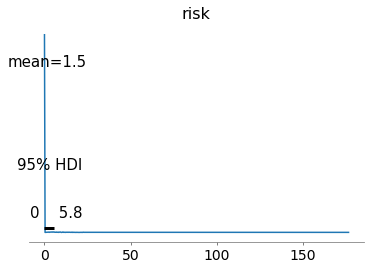

In [22]:
# Plot the results with a 95% credible interval
pm.plot_posterior(trace, var_names=['risk'], hdi_prob=CONFIDENCE_INTERVAL)
plt.show()

In [23]:
POSTERIOR_MIN = .5

In [37]:
def update_and_compare_prior(new_frequency_observation):
    # Define the PyMC3 model for the prior
    with pm.Model() as prior_model:
        # Model magnitude as a log-normal distribution
        magnitude = pm.Lognormal('magnitude', mu=MU, sigma=SIGMA)

        # Model frequency as a Poisson distribution with an initial prior
        frequency_prior = pm.Poisson('frequency_prior', mu=MIN)

        # Calculate risk as the multiplication of frequency and magnitude
        risk_prior = pm.Deterministic('risk', pm.math.sum(frequency_prior * magnitude))

        # Sample from the prior
        trace_prior = pm.sample(NUM_SAMPLES, tune=1000)

    # Define the PyMC3 model for the posterior
    with prior_model:
        # Update the prior for frequency with a new observation
        frequency_prior.observed = new_frequency_observation

        # Resample from the model
        trace_posterior = pm.sample(NUM_SAMPLES, tune=1000)

    # Plot the prior and posterior distributions
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    pm.plot_posterior(trace_posterior, var_names=['risk'], ax=axes[0], hdi_prob=0.95)
    axes[0].set_title('Posterior Distribution')

    # Optionally, you can also plot the prior distribution
    pm.plot_posterior(trace_prior, var_names=['risk'], ax=axes[1], hdi_prob=0.95)
    axes[1].set_title('Prior Distribution')

    plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [magnitude]
>Metropolis: [frequency_prior]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [magnitude]
>Metropolis: [frequency_prior]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


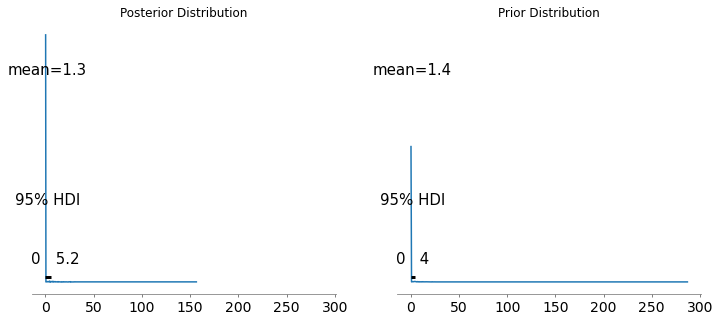

In [38]:
# Run the function to update and compare the prior and posterior
update_and_compare_prior(new_frequency_observation=POSTERIOR_MIN)